In [1]:
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import numpy as np
import random
import os
import urllib.request
import tarfile
from tqdm import tqdm
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

## Drive Synchronization

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

def sync_drive(forward=True):
    if forward:
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/models" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/dataloaders" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/experiments" "/content"
        !cp -r "/content/drive/MyDrive/mvp-semantic-mask-refinement/utils" "/content"
    else:
        !cp -r "/content/checkpoints" "/content/drive/MyDrive/mvp-semantic-mask-refinement"


Mounted at /content/drive


In [3]:
sync_drive(True)

## Configuration

In [4]:
BATCH_SIZE = 64
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = 3
NUM_WORKERS = 2
PIN_MEMORY = torch.cuda.is_available()

DATASET_NAME = "oxford-pets"
MODEL_RESULTS_DIR = os.path.join("checkpoints", DATASET_NAME)
DATA_DIR = os.path.join("./data", DATASET_NAME)

os.makedirs(MODEL_RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

## Oxford-Pets Dataset

### Loadin Dataset

In [5]:
ZIP_PATH="/content/oxford-pets.zip"

os.makedirs(DATA_DIR, exist_ok=True)
!unzip -q "{ZIP_PATH}" -d "{DATA_DIR}"

!ls -R "{DATA_DIR}"

Streaming output truncated to the last 5000 lines.
./data/oxford-pets/__MACOSX/train_images/British_Shorthair:

./data/oxford-pets/__MACOSX/train_images/chihuahua:

./data/oxford-pets/__MACOSX/train_images/Egyptian_Mau:

./data/oxford-pets/__MACOSX/train_images/english_cocker_spaniel:

./data/oxford-pets/__MACOSX/train_images/english_setter:

./data/oxford-pets/__MACOSX/train_images/german_shorthaired:

./data/oxford-pets/__MACOSX/train_images/great_pyrenees:

./data/oxford-pets/__MACOSX/train_images/havanese:

./data/oxford-pets/__MACOSX/train_images/japanese_chin:

./data/oxford-pets/__MACOSX/train_images/keeshond:

./data/oxford-pets/__MACOSX/train_images/leonberger:

./data/oxford-pets/__MACOSX/train_images/Maine_Coon:

./data/oxford-pets/__MACOSX/train_images/miniature_pinscher:

./data/oxford-pets/__MACOSX/train_images/newfoundland:

./data/oxford-pets/__MACOSX/train_images/Persian:

./data/oxford-pets/__MACOSX/train_images/pomeranian:

./data/oxford-pets/__MACOSX/train_images/pu

### Train-Val-Test-Split

In [ ]:
import importlib
import dataloaders.coco_dataset
importlib.reload(dataloaders.coco_dataset)

<module 'dataloaders.coco_dataset' from '/content/dataloaders/coco_dataset.py'>

In [7]:
from dataloaders.oxford_dataset import PetsDataset, image_transform, map_transform, MEAN_RGB, STDDEV_RGB

train_full = PetsDataset(DATA_DIR, True, image_transform, map_transform)

test_set = PetsDataset(DATA_DIR, False, image_transform, map_transform)

# ---- create train/val split from the original train_full ----
val_ratio = 0.2  # 20% of original train as validation
num_train = len(train_full)
num_val   = int(num_train * val_ratio)
num_train = num_train - num_val

print(f"Total: {len(train_full) + len(test_set)}, Train: {num_train}, Val: {num_val}, Test: {len(test_set)}")

g = torch.Generator()

train_set, val_set = torch.utils.data.random_split(
    train_full,
    [num_train, num_val],
    generator=g
)

# 2) DataLoaders
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

test_loader = DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)


Total: 7349, Train: 5080, Val: 1269, Test: 1000


### Visual Sanity Check


Images shape: torch.Size([64, 3, 160, 160]) torch.float32
Masks shape: torch.Size([64, 1, 160, 160]) torch.int64 unique: tensor([0, 1, 2])


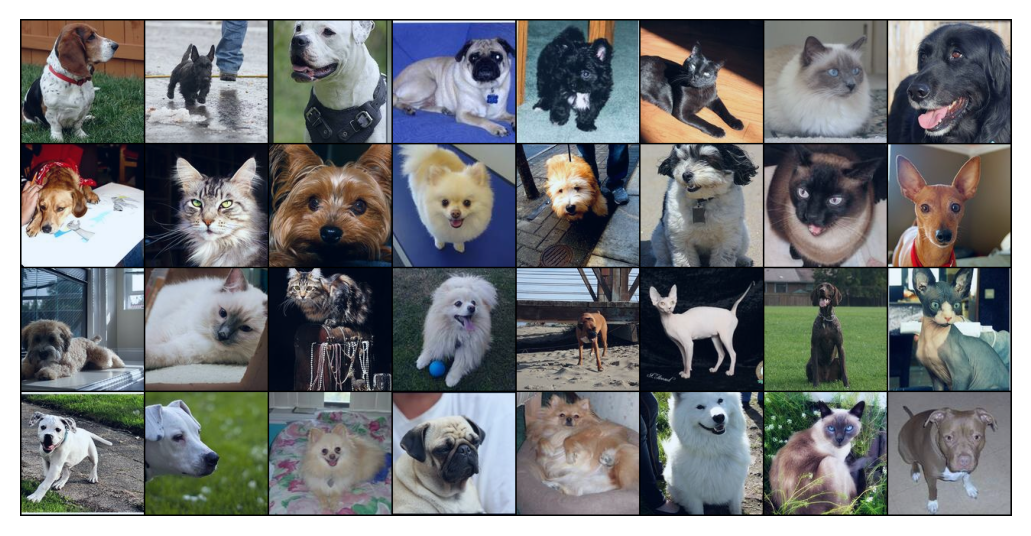

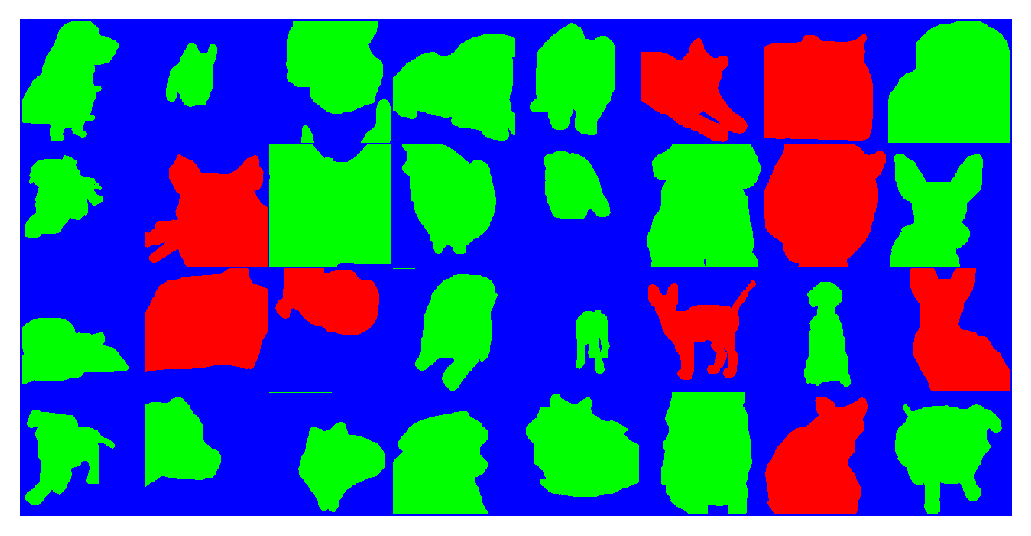

In [8]:
def show_batch(images, maps, out=None, max_images=32):
    """
    images: [B,3,H,W]
    maps:   [B,1,H,W] or [B,H,W]
    out:    optional prediction tensor, same batch size as maps
    max_images: int or None. If set, only the first max_images from the batch are shown.
    """
    plt.rcParams['figure.dpi'] = 200

    # Decide how many images to show
    B = images.size(0)
    if max_images is None:
        max_images = B
    max_images = min(max_images, B)

    images_vis = images[:max_images]
    maps_vis   = maps[:max_images]
    out_vis    = out[:max_images] if out is not None else None

    # ---- RGB images ----
    g = torchvision.utils.make_grid(images_vis, normalize=True)
    plt.imshow(g.permute(1, 2, 0).detach().cpu())
    plt.axis("off")

    # ---- predictions (if provided) ----
    if out_vis is not None:
        plt.figure()
        # if out is [B,H,W], add channel dim for make_grid
        if out_vis.dim() == 3:
            out_vis_grid = out_vis.unsqueeze(1).float()
        else:
            out_vis_grid = out_vis.float()

        g = torchvision.utils.make_grid(out_vis_grid)
        plt.imshow(
            g[0:1].permute(1, 2, 0).detach().cpu(),
            interpolation='nearest',
            cmap="brg"
        )
        plt.axis("off")

    # ---- ground truth maps ----
    plt.figure()
    # maps is [B,1,H,W] or [B,H,W] → make it [B,1,H,W]
    if maps_vis.dim() == 3:
        maps_vis_grid = maps_vis.unsqueeze(1).float()
    else:
        maps_vis_grid = maps_vis.float()

    g = torchvision.utils.make_grid(maps_vis_grid)
    plt.imshow(
        g[0:1].permute(1, 2, 0).detach().cpu(),
        interpolation='nearest',
        cmap="brg"
    )
    plt.axis("off")
    plt.show()

images, maps = next(iter(train_loader))
print("\nImages shape:", images.shape, images.dtype)
print("Masks shape:", maps.shape, maps.dtype, "unique:", maps.unique())
show_batch(images, maps, max_images=32)

## Train U-Net baseline

### Model Initialization

In [9]:
from models.unet import UNet

baseline_model = UNet(in_channels=3, num_classes=CLASSES).to(DEVICE)
print(baseline_model)

UNet(
  (down_convolution_1): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_2): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_convolution_3): DownSample(
    (conv): DoubleConv(
      (conv_op): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

### Parameters

In [10]:
optimizer_unet = torch.optim.Adam(baseline_model.parameters(), LEARNING_RATE)

total_params = 0
for p in baseline_model.parameters():
    total_params += p.numel()
print(f"{total_params / 1e6:.2f}M parameters")

31.03M parameters


### Training

In [11]:
train_losses, val_losses = [], []
train_accs, val_accs = [], []

best_val_loss = float("inf")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")

    # ===== TRAIN =====
    baseline_model.train()
    running_loss = 0.0
    running_acc = 0.0

    pbar = tqdm(train_loader, desc=f"Train {epoch+1}", leave=False)
    for images, labels in pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer_unet.zero_grad()
        logits = baseline_model(images)

        loss = torch.nn.functional.cross_entropy(logits, labels.squeeze(1))
        loss.backward()
        optimizer_unet.step()

        running_loss += loss.item()

        with torch.no_grad():
            preds = logits.argmax(1)
            acc = (preds == labels.squeeze(1)).float().mean().item() * 100
            running_acc += acc

        pbar.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.1f}%"})

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = running_acc / len(train_loader)

    train_losses.append(epoch_train_loss)
    train_accs.append(epoch_train_acc)

    # ===== VALIDATION =====
    baseline_model.eval()
    val_loss = 0.0
    val_acc = 0.0

    pbar_val = tqdm(val_loader, desc=f"Val   {epoch+1}", leave=False)
    with torch.no_grad():
        for images, labels in pbar_val:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = baseline_model(images)
            loss = torch.nn.functional.cross_entropy(logits, labels.squeeze(1))

            val_loss += loss.item()
            preds = logits.argmax(1)
            acc = (preds == labels.squeeze(1)).float().mean().item() * 100
            val_acc += acc

            pbar_val.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{acc:.1f}%"})

    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_acc = val_acc / len(val_loader)

    val_losses.append(epoch_val_loss)
    val_accs.append(epoch_val_acc)

    # ===== SUMMARY PRINT =====
    print(
        f"Epoch {epoch+1}: "
        f"train_loss={epoch_train_loss:.4f}, val_loss={epoch_val_loss:.4f}, "
        f"train_acc={epoch_train_acc:.1f}%, val_acc={epoch_val_acc:.1f}%"
    )

    # ===== SAVE BEST MODEL ONLY =====
    state = {
        "epoch": epoch + 1,
        "net": baseline_model.state_dict(),
        "optimizer": optimizer_unet.state_dict(),
        "val_loss": epoch_val_loss,
    }

    # Save last model always
    torch.save(state, os.path.join(MODEL_RESULTS_DIR, "unet_last.pt"))

    # Save best by validation loss
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(state, os.path.join(MODEL_RESULTS_DIR, "unet_best.pt"))
        print(f"New best model saved (val_loss={best_val_loss:.4f})")


Epoch 1/20


Epoch 1: train_loss=0.9902, val_loss=0.9464, train_acc=50.2%, val_acc=56.5%
New best model saved (val_loss=0.9464)

Epoch 2/20


Epoch 2: train_loss=0.8503, val_loss=0.8002, train_acc=62.5%, val_acc=65.7%
New best model saved (val_loss=0.8002)

Epoch 3/20


Epoch 3: train_loss=0.7772, val_loss=0.7782, train_acc=66.5%, val_acc=66.4%
New best model saved (val_loss=0.7782)

Epoch 4/20


Epoch 4: train_loss=0.7194, val_loss=0.6737, train_acc=68.8%, val_acc=71.1%
New best model saved (val_loss=0.6737)

Epoch 5/20


Epoch 5: train_loss=0.6836, val_loss=0.6480, train_acc=70.2%, val_acc=71.9%
New best model saved (val_loss=0.6480)

Epoch 6/20


Epoch 6: train_loss=0.6406, val_loss=0.6105, train_acc=71.8%, val_acc=73.5%
New best model saved (val_loss=0.6105)

Epoch 7/20


Epoch 7: train_loss=0.6183, val_loss=0.5951, train_acc=72.7%, val_acc=74.0%
New best model saved (val_loss=0.5951)

Epoch 8/20


Epoch 8: train_loss=0.5993, val_loss=0.5876, train_acc=73.4%, val_acc=74.2%
New best model saved (val_loss=0.5876)

Epoch 9/20


Epoch 9: train_loss=0.5750, val_loss=0.5491, train_acc=74.0%, val_acc=75.2%
New best model saved (val_loss=0.5491)

Epoch 10/20


Epoch 10: train_loss=0.5531, val_loss=0.6424, train_acc=74.6%, val_acc=75.1%

Epoch 11/20


Epoch 11: train_loss=0.5514, val_loss=0.5202, train_acc=75.2%, val_acc=77.5%
New best model saved (val_loss=0.5202)

Epoch 12/20


Epoch 12: train_loss=0.5074, val_loss=0.5198, train_acc=78.2%, val_acc=78.0%
New best model saved (val_loss=0.5198)

Epoch 13/20


Epoch 13: train_loss=0.4883, val_loss=0.4917, train_acc=79.9%, val_acc=80.4%
New best model saved (val_loss=0.4917)

Epoch 14/20


Epoch 14: train_loss=0.4440, val_loss=0.4567, train_acc=82.4%, val_acc=82.4%
New best model saved (val_loss=0.4567)

Epoch 15/20


Epoch 15: train_loss=0.4076, val_loss=0.4292, train_acc=84.2%, val_acc=83.2%
New best model saved (val_loss=0.4292)

Epoch 16/20


Epoch 16: train_loss=0.3749, val_loss=0.4136, train_acc=85.5%, val_acc=84.0%
New best model saved (val_loss=0.4136)

Epoch 17/20


Epoch 17: train_loss=0.3445, val_loss=0.3905, train_acc=86.8%, val_acc=85.3%
New best model saved (val_loss=0.3905)

Epoch 18/20


Epoch 18: train_loss=0.2996, val_loss=0.4098, train_acc=88.6%, val_acc=84.1%

Epoch 19/20


Epoch 19: train_loss=0.2763, val_loss=0.3721, train_acc=89.5%, val_acc=86.4%
New best model saved (val_loss=0.3721)

Epoch 20/20


Epoch 20: train_loss=0.2593, val_loss=0.3663, train_acc=90.2%, val_acc=86.5%
New best model saved (val_loss=0.3663)


### Plotting losses

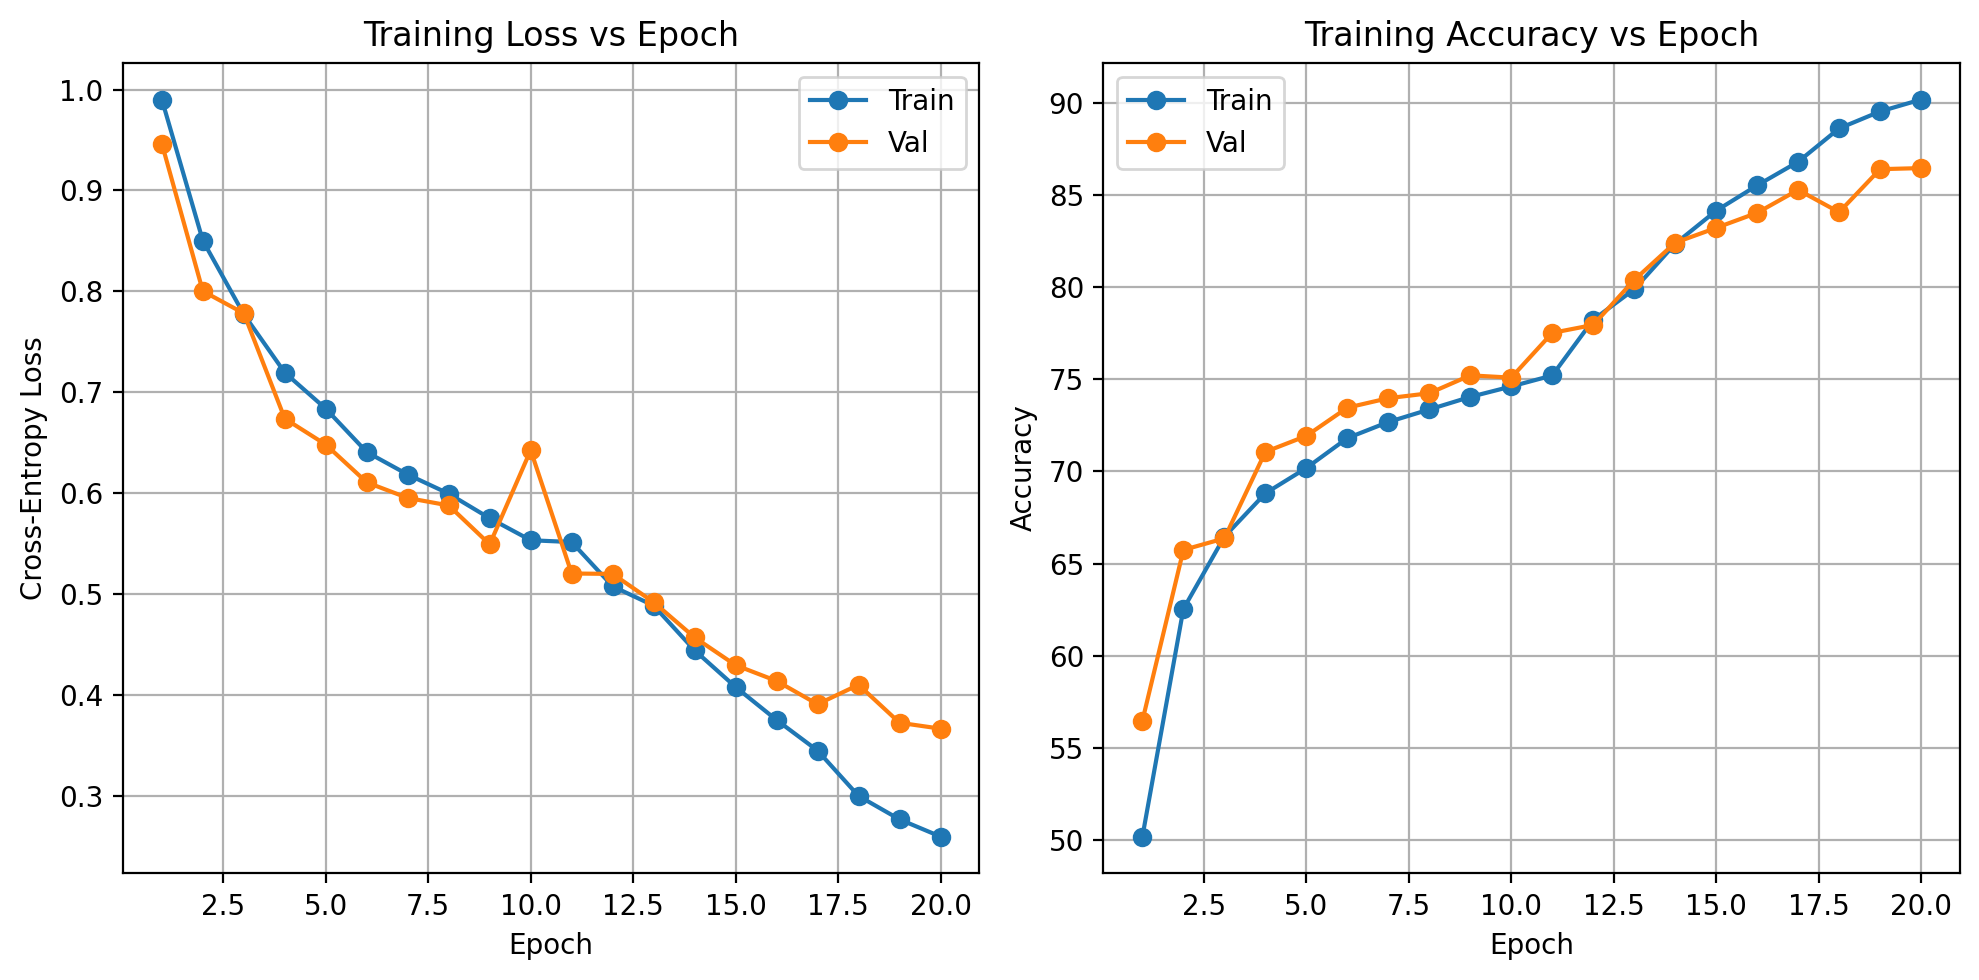

In [12]:
epochs = range(1, NUM_EPOCHS + 1)
sync_drive(False)

fig, ax = plt.subplots(1,2, figsize=(10,5))
# Loss
ax[0].plot(epochs, train_losses, marker='o')
ax[0].plot(epochs, val_losses, marker='o')
ax[0].legend(["Train", "Val"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Cross-Entropy Loss")
ax[0].set_title("Training Loss vs Epoch")
ax[0].grid(True)

# Accuracy
ax[1].plot(epochs, train_accs, marker='o')
ax[1].plot(epochs, val_accs, marker='o')
ax[1].legend(["Train", "Val"])
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Training Accuracy vs Epoch")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Evaluation

In [38]:
from utils.metrics import boundary_f1_score, boundary_f1_single

@torch.no_grad()
def evaluate_baseline_on_test(model, loader, num_classes, device=DEVICE):
    model.eval()
    confusion = torch.zeros(num_classes ** 2, dtype=torch.int64)

    for images, labels in tqdm(loader, desc="Testing (Baseline)"):
        images = images.to(device)
        labels = labels.to(device).squeeze(1)   # (B,H,W)

        logits = model(images)                  # (B,C,H,W)
        preds = logits.argmax(1)                # (B,H,W)

        entries = preds * num_classes + labels
        counts = torch.bincount(entries.view(-1), minlength=num_classes ** 2)
        confusion += counts.cpu()

    confusion = confusion.view(num_classes, num_classes)

    # Accuracy
    acc = 100.0 * confusion.diag().sum().float() / confusion.sum().float()

    # boundary F1
    bf1 = boundary_f1_score(model, loader, num_classes, device,
                        tolerance=2, ignore_background=True)

    # IoU per class + mIoU
    eps = 1e-6
    intersection = confusion.diag().float()
    union = confusion.sum(0).float() + confusion.sum(1).float() - intersection
    iou = (intersection / (union + eps)).tolist()
    miou = sum(iou) / len(iou)

    print("\n" + "=" * 60)
    print("BASELINE U-NET EVALUATION (test set)")
    print("=" * 60)
    print(f"Accuracy: {acc:.2f}%")
    print(f"IoU per class: {iou}")
    print(f"mIoU: {miou:.4f}")
    print(f"Boundary F1 (mean over classes, tol=2 px): {bf1:.4f}")
    print("=" * 60)

    return confusion, acc.item(), iou, miou, bf1

In [39]:
data_unet = torch.load(os.path.join(MODEL_RESULTS_DIR, "unet_best.pt"), map_location=DEVICE)
baseline_model.load_state_dict(data_unet["net"])
baseline_model.eval()

conf_base, acc_base, iou_base, miou_base, bf1_base = evaluate_baseline_on_test(baseline_model, test_loader, CLASSES)

Testing (Baseline): 100%|██████████| 16/16 [00:01<00:00, 13.13it/s]



BASELINE U-NET EVALUATION (test set)
Accuracy: 86.24%
IoU per class: [0.8378522992134094, 0.6190240979194641, 0.7287351489067078]
mIoU: 0.7285
Boundary F1 (mean over classes, tol=2 px): 0.3540


### Visualizing Predictions

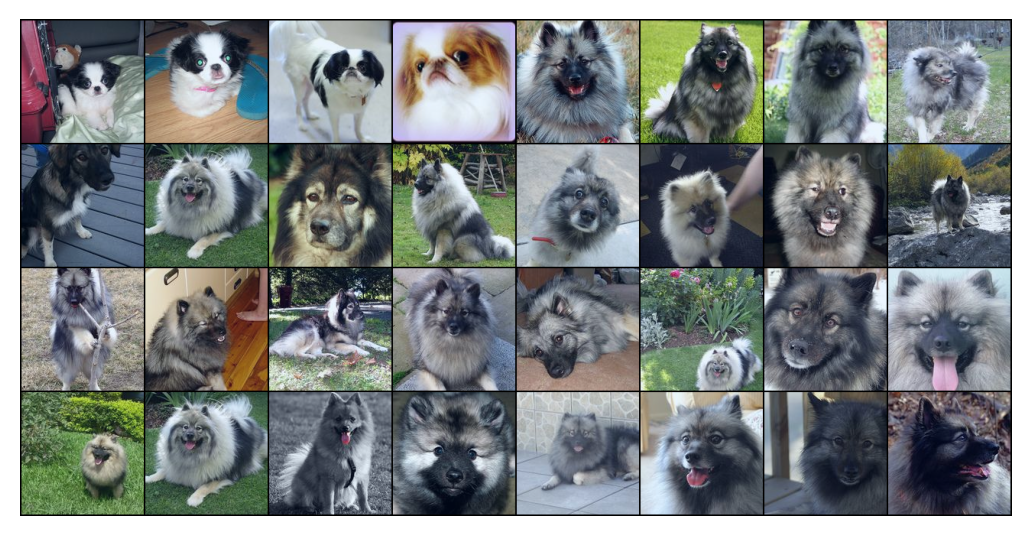

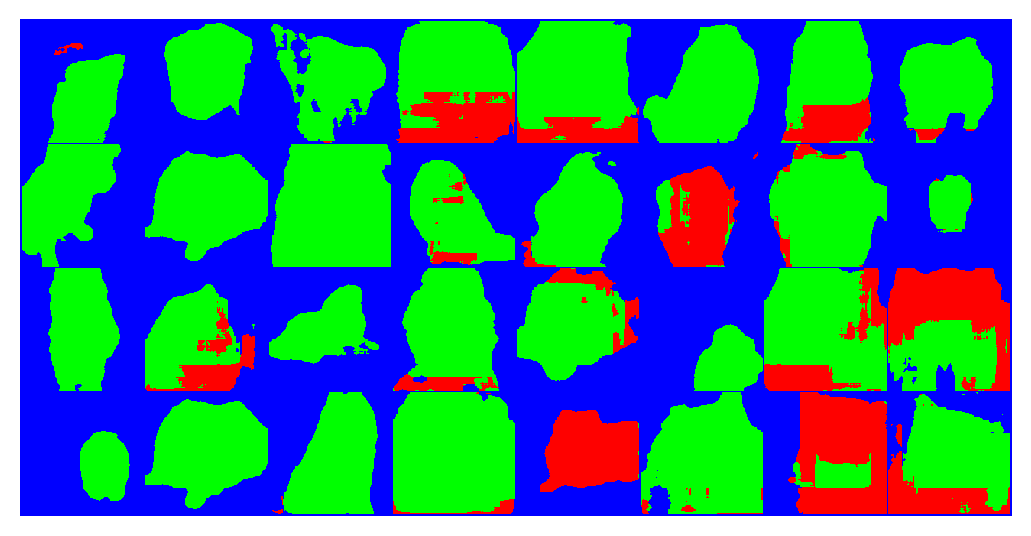

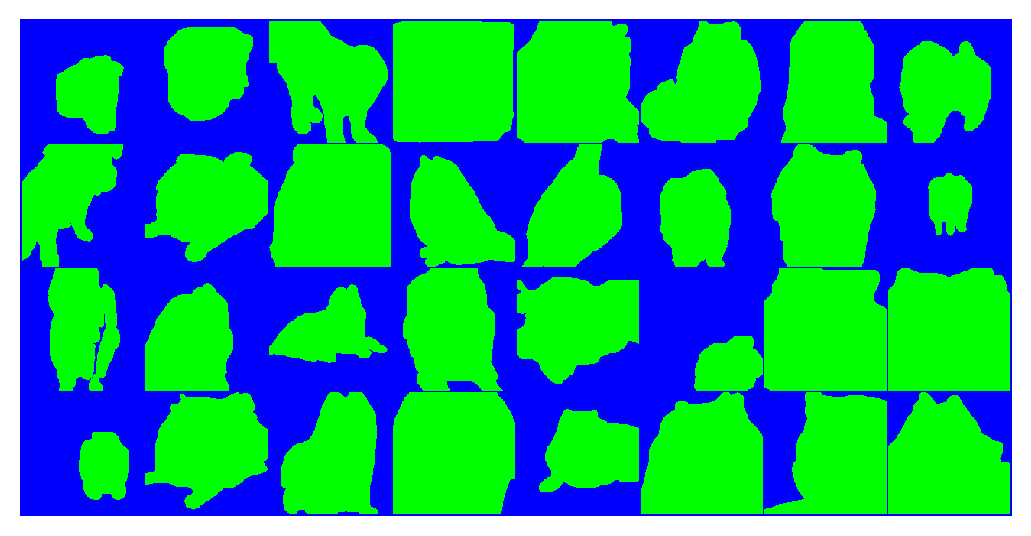

In [32]:
iter_l = iter(test_loader)
for _ in range(10):
    images, maps = next(iter_l)

images, maps = next(iter(iter_l))

# images, maps = next(iter(test_loader))
# images, maps = next(iter(test_loader))
# images, maps = next(iter(test_loader))


out = baseline_model(images.to(DEVICE)).argmax(1, True).to("cpu")
show_batch(images, maps, out)

## Residual Diffusion Refiner

### Model Initialization

In [15]:
from models.diffusion_refiner import DiffusionUNet, batch_mean_iou, q_sample, build_diffusion_input, T

# in_channels = C (x_t) + 1 (t) + C (probs) + C (logits) + 3 (RGB) = 3C + 4
diff_in_channels = 3 * CLASSES + 4
diff_out_channels = CLASSES  # residual over logits per class

diffusion_model = DiffusionUNet(
    in_channels=diff_in_channels,
    out_channels=diff_out_channels,
    base_channels=32,
    depth=3
).to(DEVICE)

### Model Parameters

In [16]:
total_params = 0
for p in diffusion_model.parameters():
    total_params += p.numel()
print(f"{total_params / 1e6:.2f}M parameters")

0.85M parameters


### Training

In [17]:
# Training config
EPOCHS_DIFF = NUM_EPOCHS
LR_DIFF = 5e-4
optimizer_diff = torch.optim.Adam(diffusion_model.parameters(), lr=LR_DIFF)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_diff, step_size=4, gamma=0.5)

best_val_loss_diff = float("inf")

In [18]:
def train_diffusion_epoch(model, baseline_model, loader, optimizer, device, num_classes):
    model.train()
    baseline_model.eval()
    total_loss = 0.0
    total_miou = 0.0

    pbar = tqdm(loader, desc="Diffusion Train", leave=False)
    for images, labels in pbar:
        images = images.to(device)             # (B,3,H,W)
        labels = labels.to(device).squeeze(1)  # (B,H,W) long

        # 1) baseline logits + probabilities (our "clean" x0)
        with torch.no_grad():
            logits_base = baseline_model(images)          # (B,C,H,W)
            base_probs = F.softmax(logits_base, dim=1)    # (B,C,H,W)

        # 2) sample timestep t ∈ [0, T]
        B = labels.size(0)
        t = torch.randint(0, T + 1, (B,), device=device).long()

        # 3) forward noising of baseline probs
        x_t = q_sample(base_probs, t)                     # (B,C,H,W)

        # 4) build input: noisy baseline + t + baseline probs + logits + image
        x_in = build_diffusion_input(x_t, t, base_probs, logits_base, images)

        # 5) predict residual logits
        delta_logits = model(x_in)                        # (B,C,H,W)

        # 6) refined logits = baseline logits + residual
        refined_logits = logits_base + delta_logits

        # 7) loss vs ground truth labels (cross-entropy)
        loss = F.cross_entropy(refined_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # quick mIoU for monitoring
        preds_classes = refined_logits.argmax(1)          # (B,H,W)
        batch_miou = batch_mean_iou(preds_classes, labels, num_classes)
        total_miou += batch_miou

        pbar.set_postfix(loss=f"{loss.item():.4f}", mIoU=f"{batch_miou:.3f}")

    avg_loss = total_loss / len(loader)
    avg_miou = total_miou / len(loader)
    return avg_loss, avg_miou


@torch.no_grad()
def validate_diffusion_epoch(model, baseline_model, loader, device, num_classes):
    model.eval()
    baseline_model.eval()
    total_loss = 0.0
    total_miou = 0.0

    pbar = tqdm(loader, desc="Diffusion Validation", leave=False)
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device).squeeze(1)   # (B,H,W)

        logits_base = baseline_model(images)
        base_probs = F.softmax(logits_base, dim=1)

        B = labels.size(0)
        t = torch.randint(0, T + 1, (B,), device=device).long()

        x_t = q_sample(base_probs, t)
        x_in = build_diffusion_input(x_t, t, base_probs, logits_base, images)
        delta_logits = model(x_in)
        refined_logits = logits_base + delta_logits

        loss = F.cross_entropy(refined_logits, labels)
        total_loss += loss.item()

        preds_classes = refined_logits.argmax(1)
        batch_miou = batch_mean_iou(preds_classes, labels, num_classes)
        total_miou += batch_miou

    avg_loss = total_loss / len(loader)
    avg_miou = total_miou / len(loader)
    return avg_loss, avg_miou

In [19]:
diffusion_train_losses, diffusion_val_losses = [], []
diffusion_train_mious, diffusion_val_mious = [], []

for epoch in range(1, EPOCHS_DIFF + 1):
    print(f"\n=== Residual Diffusion Refiner Epoch {epoch}/{EPOCHS_DIFF} ===")
    train_loss, train_miou = train_diffusion_epoch(
        diffusion_model, baseline_model, train_loader, optimizer_diff, DEVICE, CLASSES
    )

    diffusion_train_losses.append(train_loss)
    diffusion_train_mious.append(train_miou)

    val_loss, val_miou = validate_diffusion_epoch(
        diffusion_model, baseline_model, val_loader, DEVICE, CLASSES
    )

    diffusion_val_losses.append(val_loss)
    diffusion_val_mious.append(val_miou)

    print(f"Train: loss={train_loss:.4f}, mIoU={train_miou:.4f}")
    print(f"Val:   loss={val_loss:.4f}, mIoU={val_miou:.4f}")

    # save "last" diffusion model
    diff_state = {
        "epoch": epoch,
        "net": diffusion_model.state_dict(),
        "optimizer": optimizer_diff.state_dict(),
        "val_loss": val_loss,
        "val_mIoU": val_miou,
    }
    torch.save(diff_state, os.path.join(MODEL_RESULTS_DIR, "diffusion_last.pt"))

    # save "best" diffusion model (by lowest val_loss)
    if val_loss < best_val_loss_diff:
        best_val_loss_diff = val_loss
        torch.save(diff_state, os.path.join(MODEL_RESULTS_DIR, "diffusion_best.pt"))
        print(f"New best diffusion model saved (val_loss={best_val_loss_diff:.4f})")

    scheduler.step()


=== Residual Diffusion Refiner Epoch 1/20 ===


Train: loss=0.1972, mIoU=0.8557
Val:   loss=0.4140, mIoU=0.7602
New best diffusion model saved (val_loss=0.4140)

=== Residual Diffusion Refiner Epoch 2/20 ===


Train: loss=0.1855, mIoU=0.8637
Val:   loss=0.3582, mIoU=0.7639
New best diffusion model saved (val_loss=0.3582)

=== Residual Diffusion Refiner Epoch 3/20 ===


Train: loss=0.1836, mIoU=0.8650
Val:   loss=0.3953, mIoU=0.7641

=== Residual Diffusion Refiner Epoch 4/20 ===


Train: loss=0.1800, mIoU=0.8678
Val:   loss=0.3694, mIoU=0.7675

=== Residual Diffusion Refiner Epoch 5/20 ===


Train: loss=0.1767, mIoU=0.8700
Val:   loss=0.3577, mIoU=0.7679
New best diffusion model saved (val_loss=0.3577)

=== Residual Diffusion Refiner Epoch 6/20 ===


Train: loss=0.1755, mIoU=0.8710
Val:   loss=0.3560, mIoU=0.7676
New best diffusion model saved (val_loss=0.3560)

=== Residual Diffusion Refiner Epoch 7/20 ===


Train: loss=0.1755, mIoU=0.8705
Val:   loss=0.3539, mIoU=0.7682
New best diffusion model saved (val_loss=0.3539)

=== Residual Diffusion Refiner Epoch 8/20 ===


Train: loss=0.1741, mIoU=0.8713
Val:   loss=0.3578, mIoU=0.7693

=== Residual Diffusion Refiner Epoch 9/20 ===


Train: loss=0.1733, mIoU=0.8716
Val:   loss=0.3531, mIoU=0.7691
New best diffusion model saved (val_loss=0.3531)

=== Residual Diffusion Refiner Epoch 10/20 ===


Train: loss=0.1722, mIoU=0.8728
Val:   loss=0.3623, mIoU=0.7707

=== Residual Diffusion Refiner Epoch 11/20 ===


Train: loss=0.1722, mIoU=0.8722
Val:   loss=0.3543, mIoU=0.7709

=== Residual Diffusion Refiner Epoch 12/20 ===


Train: loss=0.1717, mIoU=0.8732
Val:   loss=0.3542, mIoU=0.7704

=== Residual Diffusion Refiner Epoch 13/20 ===


Train: loss=0.1704, mIoU=0.8735
Val:   loss=0.3571, mIoU=0.7706

=== Residual Diffusion Refiner Epoch 14/20 ===


Train: loss=0.1698, mIoU=0.8738
Val:   loss=0.3588, mIoU=0.7705

=== Residual Diffusion Refiner Epoch 15/20 ===


Train: loss=0.1696, mIoU=0.8739
Val:   loss=0.3624, mIoU=0.7707

=== Residual Diffusion Refiner Epoch 16/20 ===


Train: loss=0.1688, mIoU=0.8748
Val:   loss=0.3570, mIoU=0.7710

=== Residual Diffusion Refiner Epoch 17/20 ===


Train: loss=0.1683, mIoU=0.8750
Val:   loss=0.3627, mIoU=0.7719

=== Residual Diffusion Refiner Epoch 18/20 ===


Train: loss=0.1673, mIoU=0.8753
Val:   loss=0.3623, mIoU=0.7715

=== Residual Diffusion Refiner Epoch 19/20 ===


Train: loss=0.1678, mIoU=0.8749
Val:   loss=0.3601, mIoU=0.7715

=== Residual Diffusion Refiner Epoch 20/20 ===


Train: loss=0.1676, mIoU=0.8750
Val:   loss=0.3609, mIoU=0.7720


### Plotting losses

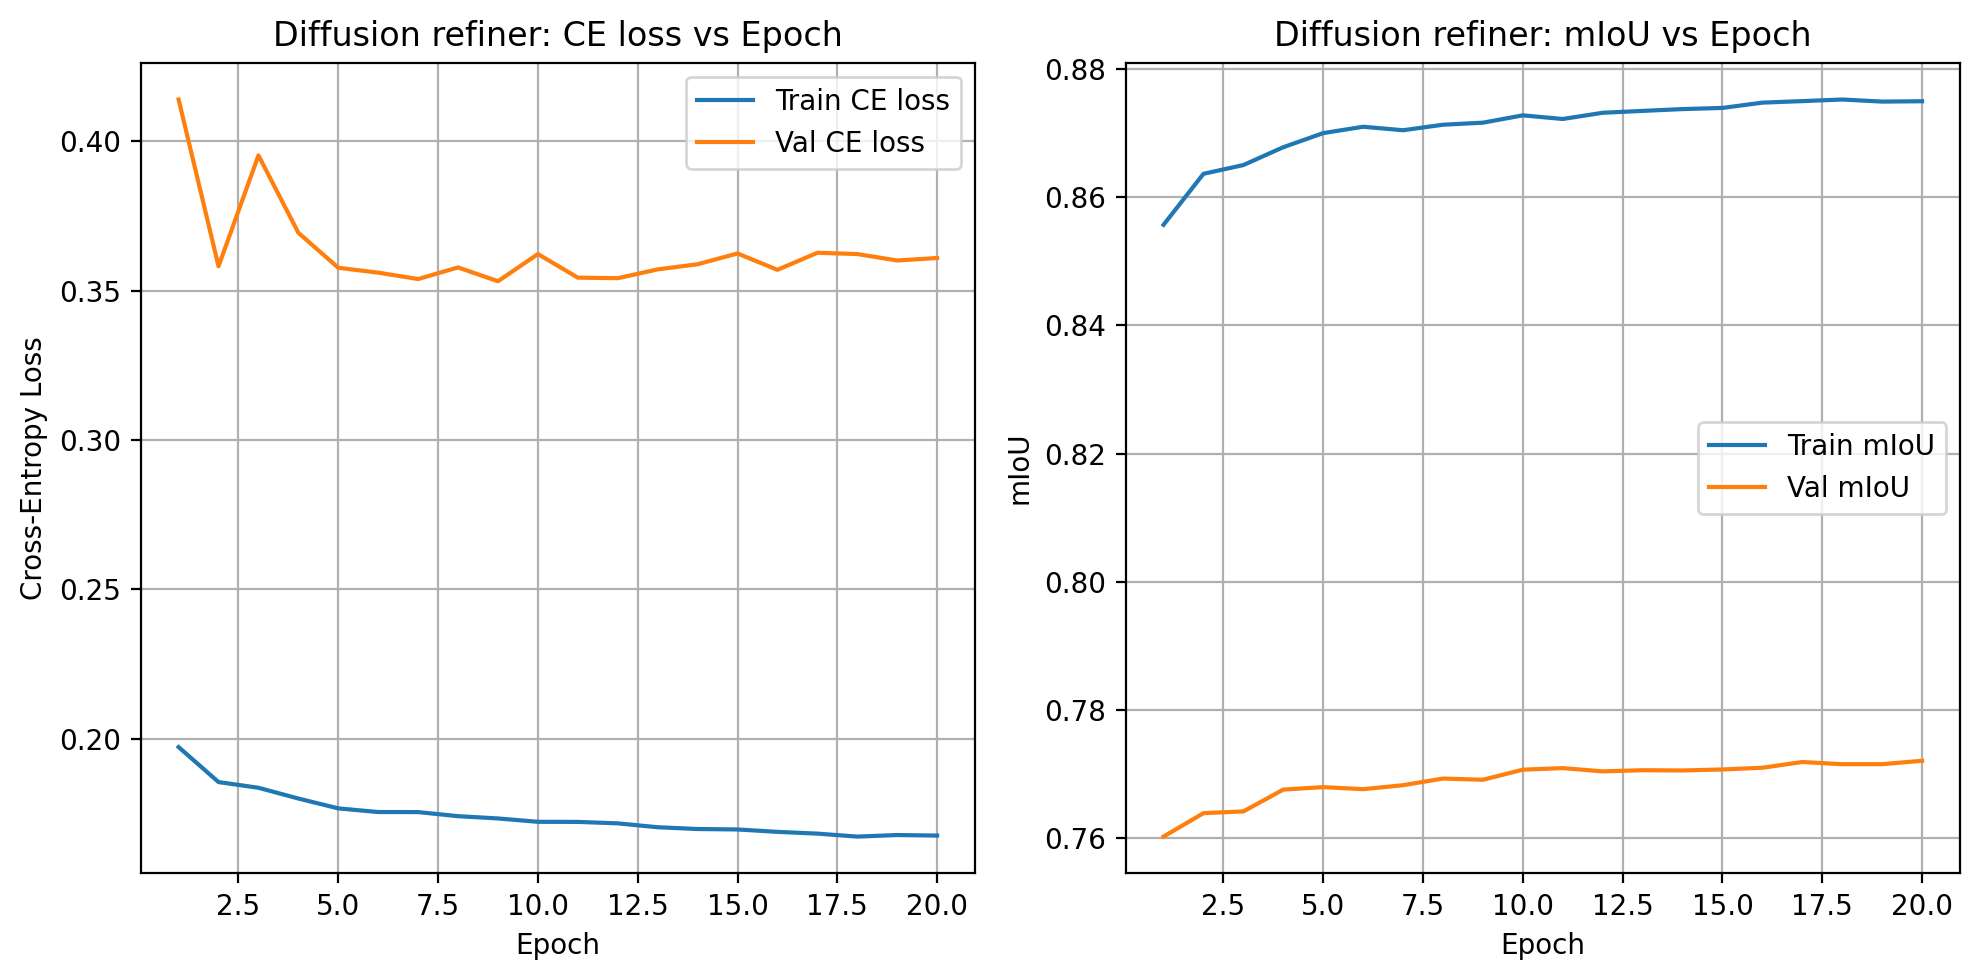

In [20]:
epochs = range(1, EPOCHS_DIFF + 1)
sync_drive(False)

fig, ax = plt.subplots(1,2, figsize=(10,5))
# Loss
ax[0].plot(epochs, diffusion_train_losses, label="Train CE loss")
ax[0].plot(epochs, diffusion_val_losses,   label="Val CE loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Cross-Entropy Loss")
ax[0].set_title("Diffusion refiner: CE loss vs Epoch")
ax[0].legend()
ax[0].grid(True)

# Accuracy
ax[1].plot(epochs, diffusion_train_mious, label="Train mIoU")
ax[1].plot(epochs, diffusion_val_mious, label="Val mIoU")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("mIoU")
ax[1].set_title("Diffusion refiner: mIoU vs Epoch")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()

# Save both plots in the same image
# plt.savefig(os.path.join(PROJECT_DIR, f"r_classes{CLASSES}_diff_ref_T{T}_epoch{EPOCHS_DIFF}_loss_mIoU.png"), dpi=200)

plt.show()

### Evaluation

In [21]:
data_diffusion = torch.load(os.path.join(MODEL_RESULTS_DIR, "diffusion_best.pt"), map_location=DEVICE)
diffusion_model.load_state_dict(data_diffusion["net"])
diffusion_model.eval()

DiffusionUNet(
  (encoder): ModuleList(
    (0): DiffConvBlock(
      (down): Identity()
      (conv1): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (up): Identity()
    )
    (1): DiffConvBlock(
      (down): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (up): Identity()
    )
    (2): DiffConvBlock(
      (down): MaxPoo

In [22]:
@torch.no_grad()
def refine_with_diffusion(diffusion_model, baseline_model, images, t_start=0):
    """
    images: (B,3,H,W)
    t_start: integer in [0, T]; 0 = no noise, >0 = add diffusion noise
    returns:
        base_logits:   baseline logits (B,C,H,W)
        refined_probs: diffusion-refined probabilities (B,C,H,W)
    """
    baseline_model.eval()
    diffusion_model.eval()

    images = images.to(DEVICE)
    logits_base = baseline_model(images)                 # (B,C,H,W)
    probs_base = F.softmax(logits_base, dim=1)           # (B,C,H,W)

    B = images.size(0)
    t_start = max(0, min(T, int(t_start)))
    t = torch.full((B,), t_start, device=DEVICE, dtype=torch.long)

    # baseline probs as "clean" x0 → possibly noised
    x_t = q_sample(probs_base, t)                        # (B,C,H,W)
    x_in = build_diffusion_input(x_t, t, probs_base, logits_base, images)
    delta_logits = diffusion_model(x_in)                 # (B,C,H,W)

    refined_logits = logits_base + delta_logits
    refined_probs = F.softmax(refined_logits, dim=1)
    return logits_base, refined_probs

@torch.no_grad()
def boundary_f1_score_diffusion(
    diffusion_model,
    baseline_model,
    loader,
    num_classes,
    device,
    t_start=0,
    tolerance=2,
    ignore_background=True,
):
    """
    Mean boundary F1 over all images in loader,
    using the diffusion refiner at a fixed t_start.
    """
    diffusion_model.eval()
    baseline_model.eval()

    total_f1 = 0.0
    count = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device).squeeze(1)  # (B,H,W)

        # get refined probabilities from your diffusion pipeline
        _, refined_probs = refine_with_diffusion(
            diffusion_model, baseline_model, images, t_start=t_start
        )
        preds = refined_probs.argmax(1)        # (B,H,W)

        for b in range(images.size(0)):
            f1 = boundary_f1_single(
                labels[b],
                preds[b],
                num_classes=num_classes,
                tolerance=tolerance,
                ignore_background=ignore_background,
            )
            total_f1 += f1
            count += 1

    return total_f1 / max(count, 1)

@torch.no_grad()
def evaluate_diffusion_on_test(diffusion_model, baseline_model, loader, t_start, num_classes):
    diffusion_model.eval()
    baseline_model.eval()

    confusion = torch.zeros(num_classes ** 2, dtype=torch.int64)

    for images, labels in tqdm(loader, desc=f"Testing (Diffusion, t_start={t_start})"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).squeeze(1)     # (B,H,W)

        _, refined_probs = refine_with_diffusion(diffusion_model, baseline_model, images, t_start)
        preds = refined_probs.argmax(1)           # (B,H,W)

        entries = preds * num_classes + labels
        counts = torch.bincount(entries.view(-1), minlength=num_classes ** 2)
        confusion += counts.cpu()

    confusion = confusion.view(num_classes, num_classes)
    acc = 100.0 * confusion.diag().sum().float() / confusion.sum().float()

    bf1_diff = boundary_f1_score_diffusion(
        diffusion_model,   # diffusion head
        baseline_model,             # baseline U-Net (or baseline_model if that's what you used)
        loader,
        num_classes=num_classes,   # or CLASSES if you defined that
        device=DEVICE,
        t_start=t_start,
        tolerance=2,
        ignore_background=True,
    )

    intersection = confusion.diag().float()
    union = confusion.sum(0).float() + confusion.sum(1).float() - intersection
    eps = 1e-6
    iou = (intersection / (union + eps)).tolist()
    miou = sum(iou) / len(iou)

    return confusion, acc.item(), iou, miou, bf1_diff

A small sweep over `t_start` gauges how much noise to inject before refinement.

`refine_with_diffusion` rebuilds probabilities, and the loop reports accuracy/IoU for each candidate before picking the best. Boundary F1 gets recomputed to compare the refiner against the baseline UNet.

In [23]:
# Try several t_start values and pick the best by mIoU
t_candidates = [2, 5, 10, 15, 20, 50, 200, 280]
results = {}

for t_start in t_candidates:
    conf_d, acc_d, iou_d, miou_d, bf1_d = evaluate_diffusion_on_test(
        diffusion_model, baseline_model, test_loader, t_start=t_start, num_classes=CLASSES
    )
    results[t_start] = (conf_d, acc_d, iou_d, miou_d, bf1_d)
    print(f"t_start={t_start:2d} -> acc={acc_d:.2f}%, mIoU={miou_d:.4f}, bF1={bf1_d:.4f}")

# choose best
best_t = max(results.keys(), key=lambda t: results[t][3])
best_conf, best_acc, best_iou, best_miou, best_bf1 = results[best_t]

print("\n" + "=" * 60)
print(f"BEST RESIDUAL DIFFUSION HEAD (test set) across t_start candidates")
print("=" * 60)
print(f"Best t_start: {best_t}")
print(f"Accuracy: {best_acc:.2f}%")
print(f"IoU per class: {best_iou}")
print(f"mIoU: {best_miou:.4f}")
print(f"Boundary F1 (mean over classes, tol=2 px): {best_bf1:.4f}")
print("=" * 60)

Testing (Diffusion, t_start=2): 100%|██████████| 16/16 [00:01<00:00, 12.22it/s]


t_start= 2 -> acc=88.32%, mIoU=0.7664, bF1=0.5198


Testing (Diffusion, t_start=5): 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]


t_start= 5 -> acc=88.32%, mIoU=0.7664, bF1=0.5198


Testing (Diffusion, t_start=10): 100%|██████████| 16/16 [00:01<00:00, 12.36it/s]


t_start=10 -> acc=88.32%, mIoU=0.7664, bF1=0.5198


Testing (Diffusion, t_start=15): 100%|██████████| 16/16 [00:01<00:00, 12.77it/s]


t_start=15 -> acc=88.32%, mIoU=0.7664, bF1=0.5199


Testing (Diffusion, t_start=20): 100%|██████████| 16/16 [00:01<00:00, 12.63it/s]


t_start=20 -> acc=88.32%, mIoU=0.7664, bF1=0.5198


Testing (Diffusion, t_start=50): 100%|██████████| 16/16 [00:01<00:00, 12.75it/s]


t_start=50 -> acc=88.33%, mIoU=0.7665, bF1=0.5198


Testing (Diffusion, t_start=200): 100%|██████████| 16/16 [00:01<00:00, 12.74it/s]


t_start=200 -> acc=88.32%, mIoU=0.7663, bF1=0.5184


Testing (Diffusion, t_start=280): 100%|██████████| 16/16 [00:01<00:00, 12.78it/s]


t_start=280 -> acc=88.31%, mIoU=0.7660, bF1=0.5178

BEST RESIDUAL DIFFUSION HEAD (test set) across t_start candidates
Best t_start: 50
Accuracy: 88.33%
IoU per class: [0.8409106731414795, 0.6779552698135376, 0.7805448174476624]
mIoU: 0.7665
Boundary F1 (mean over classes, tol=2 px): 0.5198


### Visualization: image + GT + baseline + best diffusion

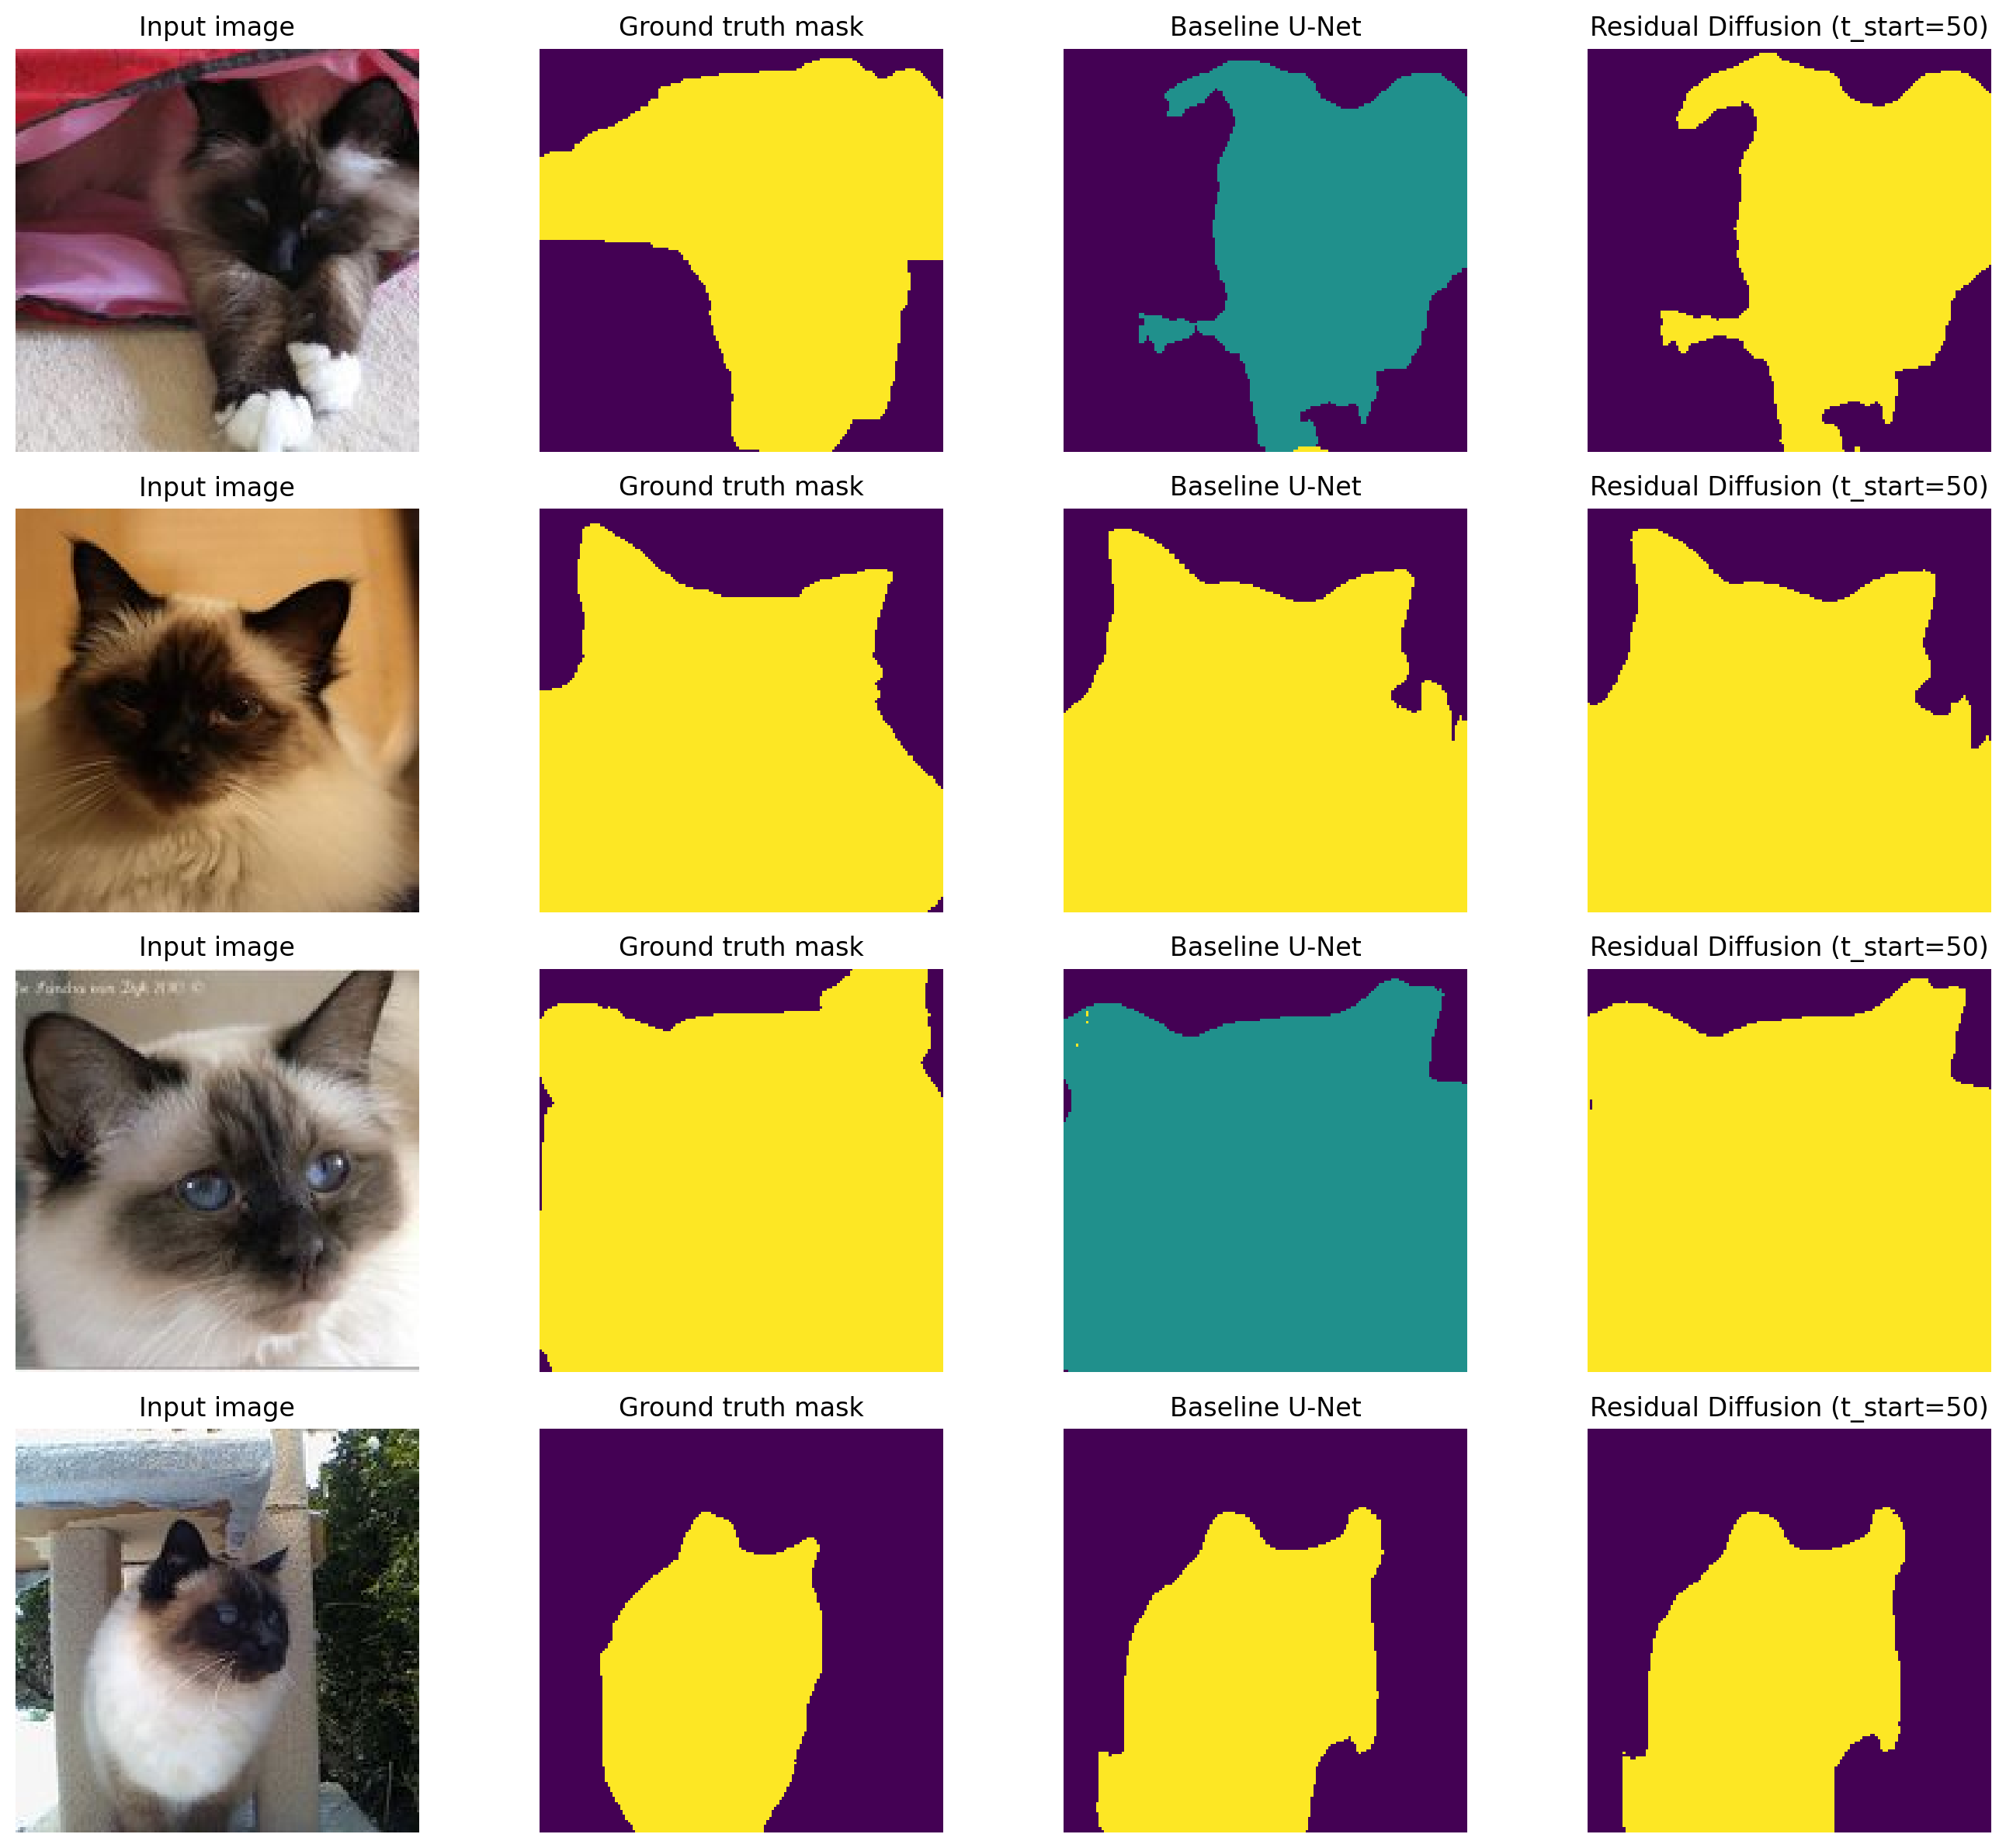

In [48]:
def denormalize_image(tensor):
    """
    tensor: (3,H,W) normalized with MEAN_RGB / STDDEV_RGB
    returns: (3,H,W) in [0,1]
    """
    mean = torch.tensor(MEAN_RGB).view(3, 1, 1)
    std = torch.tensor(STDDEV_RGB).view(3, 1, 1)
    return (tensor * std + mean).clamp(0.0, 1.0)

@torch.no_grad()
def visualize_baseline_vs_diffusion(baseline_model, diffusion_model, loader,
                                    num_samples=4, t_start=0, device=DEVICE, seed=42):
    """
    Shows: image, GT mask, baseline prediction, diffusion-refined prediction.
    """
    baseline_model.eval()
    diffusion_model.eval()

    # random images
    loader_iter = iter(loader)

    random.seed(seed)
    skip = random.randint(0, len(loader)-1)
    for _ in range(skip):
        next(loader_iter)

    images, labels = next(iter(loader_iter))   # images: (B,3,H,W), labels: (B,1,H,W)
    images = images.to(device)
    labels = labels.to(device).squeeze(1)  # (B,H,W)

    logits_base, refined_probs = refine_with_diffusion(
        diffusion_model, baseline_model, images, t_start=t_start
    )

    base_probs = F.softmax(logits_base, dim=1)
    base_preds = base_probs.argmax(1)       # (B,H,W)
    ref_preds = refined_probs.argmax(1)     # (B,H,W)

    images_cpu = images.cpu()
    labels_cpu = labels.cpu()
    base_preds_cpu = base_preds.cpu()
    ref_preds_cpu = ref_preds.cpu()

    num_samples = min(num_samples, images_cpu.size(0))
    fig, axes = plt.subplots(num_samples, 4, figsize=(14, 3 * num_samples))

    if num_samples == 1:
        axes = axes[None, :]

    for i in range(num_samples):
        # 1) input image (denormalized)
        img = denormalize_image(images_cpu[i]).permute(1, 2, 0).numpy()
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Input image")
        axes[i, 0].axis("off")

        # 2) GT mask
        axes[i, 1].imshow(labels_cpu[i], interpolation="nearest")
        axes[i, 1].set_title("Ground truth mask")
        axes[i, 1].axis("off")

        # 3) baseline prediction
        axes[i, 2].imshow(base_preds_cpu[i], interpolation="nearest")
        axes[i, 2].set_title("Baseline U-Net")
        axes[i, 2].axis("off")

        # 4) diffusion-refined prediction
        axes[i, 3].imshow(ref_preds_cpu[i], interpolation="nearest")
        axes[i, 3].set_title(f"Residual Diffusion (t_start={t_start})")
        axes[i, 3].axis("off")

    plt.tight_layout()
    plt.show()

visualize_baseline_vs_diffusion(
    baseline_model=baseline_model, diffusion_model=diffusion_model, loader=test_loader,
    num_samples=4, t_start=best_t, device=DEVICE, seed=200
)

## Runtime vs Quality (Baseline vs Diffusion Refiner)

In this cell, we evaluate the diffusion head as a **test-time post-processor** on the COCO humans test set.  
We run two kinds of experiments:

1. **Baseline U-Net:**  
   - Single forward pass of the trained U-Net.  
   - We measure runtime per image, pixel accuracy, per-class IoU, mean IoU, and Boundary-F1 (on foreground classes).

2. **Diffusion refiner with few denoising steps:**  
   - We wrap the trained diffusion head around the baseline U-Net and apply it as a post-processing step with a small number of refinement iterations (`num_steps ∈ {1, 2, 3}`) at the best timestep `t = best_t` found in Task 2.  
   - For each setting, we again measure runtime per image, accuracy, per-class IoU, mIoU, and Boundary-F1.

The printed summary at the end compares baseline vs diffusion refiner, showing the trade-off between **additional runtime** and **segmentation quality** for a few denoising steps.

In [53]:
from experiments.diffusion_runtime import (
    refine_with_multiple_steps,
    measure_baseline_runtime_and_quality,
    evaluate_refiner_runtime_quality,
)

# 1) Baseline runtime & quality on test set
baseline_rt, baseline_acc, baseline_iou, baseline_miou, baseline_bf1 = \
    measure_baseline_runtime_and_quality(
        model=baseline_model,
        loader=test_loader,
        num_classes=CLASSES,
        device=DEVICE,
    )

print("\n=== Baseline summary (test set) ===")
print(f"Runtime per image: {baseline_rt:.6f} s")
print(f"Accuracy:          {baseline_acc:.2f}%")
print(f"IoU per class:     {baseline_iou}")
print(f"mIoU:              {baseline_miou:.4f}")
print(f"Boundary F1:       {baseline_bf1:.4f}")

# 2) Diffusion refiner runtime & quality for few steps
num_steps_list = [1, 2, 3]   # "few denoising steps"
t_levels = [5, best_t, 100, 250]

all_results = {}

for t_level in t_levels:
    results_steps = evaluate_refiner_runtime_quality(
        diffusion_model=diffusion_model,
        baseline_model=baseline_model,
        loader=test_loader,
        q_sample=q_sample,
        T=T,
        num_steps_list=num_steps_list,
        t_level=best_t,           # from your Task 2 search
        num_classes=CLASSES,
        device=DEVICE,
    )
    all_results[t_level] = results_steps

print(f"\n=== Summary: Baseline vs Refiner (t_level={best_t}) ===")
print(f"Baseline: rt={baseline_rt:.6f} s, mIoU={baseline_miou:.4f}, BF1={baseline_bf1:.4f}")
for t_level, results_steps in all_results.items():
    for k in num_steps_list:
        rt, acc, iou, miou, bf1 = results_steps[k]
        print(f"t_level={t_level}, steps={k}: rt={rt:.6f} s, mIoU={miou:.4f}, BF1={bf1:.4f}")


=== Baseline summary (test set) ===
Runtime per image: 0.000058 s
Accuracy:          86.24%
IoU per class:     [0.8378522992134094, 0.6190240979194641, 0.7287351489067078]
mIoU:              0.7285
Boundary F1:       0.3540

=== Evaluating diffusion refiner: num_steps=1, t_level=50 ===


  Runtime per image: 0.000117 s
  Accuracy: 88.33%
  IoU per class: [0.8409177660942078, 0.6779112815856934, 0.7805556058883667]
  mIoU: 0.7665
  Boundary F1 (non-bg, tol=2 px): 0.5198

=== Evaluating diffusion refiner: num_steps=2, t_level=50 ===


  Runtime per image: 0.000162 s
  Accuracy: 88.32%
  IoU per class: [0.8394873738288879, 0.6727809906005859, 0.7831607460975647]
  mIoU: 0.7651
  Boundary F1 (non-bg, tol=2 px): 0.5369

=== Evaluating diffusion refiner: num_steps=3, t_level=50 ===


  Runtime per image: 0.000200 s
  Accuracy: 88.04%
  IoU per class: [0.8351194858551025, 0.661942720413208, 0.7808405756950378]
  mIoU: 0.7593
  Boundary F1 (non-bg, tol=2 px): 0.5266

=== Evaluating diffusion refiner: num_steps=1, t_level=50 ===


  Runtime per image: 0.000117 s
  Accuracy: 88.33%
  IoU per class: [0.840915858745575, 0.6778777837753296, 0.7805507183074951]
  mIoU: 0.7664
  Boundary F1 (non-bg, tol=2 px): 0.5193

=== Evaluating diffusion refiner: num_steps=2, t_level=50 ===


  Runtime per image: 0.000163 s
  Accuracy: 88.32%
  IoU per class: [0.8394933342933655, 0.672743558883667, 0.7831707000732422]
  mIoU: 0.7651
  Boundary F1 (non-bg, tol=2 px): 0.5369

=== Evaluating diffusion refiner: num_steps=3, t_level=50 ===


  Runtime per image: 0.000205 s
  Accuracy: 88.04%
  IoU per class: [0.835121750831604, 0.6618013978004456, 0.7808026075363159]
  mIoU: 0.7592
  Boundary F1 (non-bg, tol=2 px): 0.5265

=== Evaluating diffusion refiner: num_steps=1, t_level=50 ===


  Runtime per image: 0.000121 s
  Accuracy: 88.32%
  IoU per class: [0.8408933281898499, 0.6777888536453247, 0.7804909348487854]
  mIoU: 0.7664
  Boundary F1 (non-bg, tol=2 px): 0.5192

=== Evaluating diffusion refiner: num_steps=2, t_level=50 ===


  Runtime per image: 0.000168 s
  Accuracy: 88.32%
  IoU per class: [0.8394874930381775, 0.6727068424224854, 0.7831229567527771]
  mIoU: 0.7651
  Boundary F1 (non-bg, tol=2 px): 0.5372

=== Evaluating diffusion refiner: num_steps=3, t_level=50 ===


  Runtime per image: 0.000203 s
  Accuracy: 88.04%
  IoU per class: [0.8351218700408936, 0.6620309352874756, 0.7808961868286133]
  mIoU: 0.7593
  Boundary F1 (non-bg, tol=2 px): 0.5264

=== Evaluating diffusion refiner: num_steps=1, t_level=50 ===


  Runtime per image: 0.000120 s
  Accuracy: 88.32%
  IoU per class: [0.8408876061439514, 0.6778585314750671, 0.7805115580558777]
  mIoU: 0.7664
  Boundary F1 (non-bg, tol=2 px): 0.5197

=== Evaluating diffusion refiner: num_steps=2, t_level=50 ===


  Runtime per image: 0.000156 s
  Accuracy: 88.32%
  IoU per class: [0.8394867777824402, 0.6727599501609802, 0.7831517457962036]
  mIoU: 0.7651
  Boundary F1 (non-bg, tol=2 px): 0.5370

=== Evaluating diffusion refiner: num_steps=3, t_level=50 ===


  Runtime per image: 0.000198 s
  Accuracy: 88.04%
  IoU per class: [0.835124671459198, 0.6620121002197266, 0.7808464169502258]
  mIoU: 0.7593
  Boundary F1 (non-bg, tol=2 px): 0.5267

=== Summary: Baseline vs Refiner (t_level=50) ===
Baseline: rt=0.000058 s, mIoU=0.7285, BF1=0.3540
t_level=5, steps=1: rt=0.000117 s, mIoU=0.7665, BF1=0.5198
t_level=5, steps=2: rt=0.000162 s, mIoU=0.7651, BF1=0.5369
t_level=5, steps=3: rt=0.000200 s, mIoU=0.7593, BF1=0.5266
t_level=50, steps=1: rt=0.000117 s, mIoU=0.7664, BF1=0.5193
t_level=50, steps=2: rt=0.000163 s, mIoU=0.7651, BF1=0.5369
t_level=50, steps=3: rt=0.000205 s, mIoU=0.7592, BF1=0.5265
t_level=100, steps=1: rt=0.000121 s, mIoU=0.7664, BF1=0.5192
t_level=100, steps=2: rt=0.000168 s, mIoU=0.7651, BF1=0.5372
t_level=100, steps=3: rt=0.000203 s, mIoU=0.7593, BF1=0.5264
t_level=250, steps=1: rt=0.000120 s, mIoU=0.7664, BF1=0.5197
t_level=250, steps=2: rt=0.000156 s, mIoU=0.7651, BF1=0.5370
t_level=250, steps=3: rt=0.000198 s, mIoU=0.7593, BF1=

In [ ]:
import importlib
import experiments.diffusion_ablation
importlib.reload(experiments.diffusion_ablation)

<module 'experiments.diffusion_ablation' from '/content/experiments/diffusion_ablation.py'>

## Diffusion refiner ablations (conditioning & steps)

In this cell, we:
- Evaluate the baseline U-Net and the residual diffusion refiner on the full test set.
- Report accuracy, per-class IoU, mIoU, and Boundary F1.
- Study the impact of:
    - number of refinement steps (1, 2, 3)
    - different conditioning variants (full, no-image, no-logits, no-probs).
    - show a qualitative comparison (input, GT, baseline, refined masks).

In [55]:
import importlib
import experiments.diffusion_ablation
importlib.reload(experiments.diffusion_ablation)

<module 'experiments.diffusion_ablation' from '/content/experiments/diffusion_ablation.py'>


Baseline (U-Net)
  Accuracy:   86.24%
  IoU / class:[0.8378522992134094, 0.6190240979194641, 0.7287351489067078]
  mIoU:       0.7285
  Boundary F1:0.3540



Refined (full conditioning, steps=1)
  Accuracy:   88.32%
  IoU / class:[0.840928316116333, 0.6777729392051697, 0.7804305553436279]
  mIoU:       0.7664
  Boundary F1:0.5198



Refined (full conditioning, steps=2)
  Accuracy:   88.32%
  IoU / class:[0.8395746350288391, 0.6726383566856384, 0.7831584215164185]
  mIoU:       0.7651
  Boundary F1:0.5370



Refined (full conditioning, steps=3)
  Accuracy:   88.05%
  IoU / class:[0.8353503346443176, 0.6616893410682678, 0.7809743881225586]
  mIoU:       0.7593
  Boundary F1:0.5268

=== Ablation on conditioning + steps (t_level=0) ===


Refiner (mode=full, steps=1): Accuracy=88.32%, mIoU=0.7664, BF1=0.5198


Refiner (mode=full, steps=2): Accuracy=88.32%, mIoU=0.7651, BF1=0.5370


Refiner (mode=full, steps=3): Accuracy=88.05%, mIoU=0.7593, BF1=0.5268


Refiner (mode=no_image, steps=1): Accuracy=88.17%, mIoU=0.7629, BF1=0.5182


Refiner (mode=no_image, steps=2): Accuracy=88.25%, mIoU=0.7625, BF1=0.5346


Refiner (mode=no_image, steps=3): Accuracy=88.06%, mIoU=0.7577, BF1=0.5291


Refiner (mode=no_logits, steps=1): Accuracy=87.29%, mIoU=0.7466, BF1=0.4459


Refiner (mode=no_logits, steps=2): Accuracy=84.99%, mIoU=0.7055, BF1=0.3767


Refiner (mode=no_logits, steps=3): Accuracy=81.01%, mIoU=0.6425, BF1=0.2790


Refiner (mode=no_probs, steps=1): Accuracy=88.12%, mIoU=0.7622, BF1=0.4921


Refiner (mode=no_probs, steps=2): Accuracy=87.86%, mIoU=0.7548, BF1=0.4975


Refiner (mode=no_probs, steps=3): Accuracy=85.95%, mIoU=0.7109, BF1=0.4510

=== Ablation summary (t_level=0) ===
Baseline mIoU: 0.7285
Mode=full    , steps=1: mIoU=0.7664, BF1=0.5198
Mode=full    , steps=2: mIoU=0.7651, BF1=0.5370
Mode=full    , steps=3: mIoU=0.7593, BF1=0.5268
Mode=no_image, steps=1: mIoU=0.7629, BF1=0.5182
Mode=no_image, steps=2: mIoU=0.7625, BF1=0.5346
Mode=no_image, steps=3: mIoU=0.7577, BF1=0.5291
Mode=no_logits, steps=1: mIoU=0.7466, BF1=0.4459
Mode=no_logits, steps=2: mIoU=0.7055, BF1=0.3767
Mode=no_logits, steps=3: mIoU=0.6425, BF1=0.2790
Mode=no_probs, steps=1: mIoU=0.7622, BF1=0.4921
Mode=no_probs, steps=2: mIoU=0.7548, BF1=0.4975
Mode=no_probs, steps=3: mIoU=0.7109, BF1=0.4510


Method  Steps  Accuracy (%)      mIoU  IoU_class_0  IoU_class_1  \
3      Baseline      0     86.244247  0.728537     0.837852     0.619024   
0  Refined_full      1     88.322281  0.766377     0.840928     0.677773   
1  Refined_full      2     88.321220  0.765124     0.839575     0.672638   
2  Refined_full      3     88.046471  0.759338     0.835350     0.661689   

   IoU_class_2  Boundary_F1  
3     0.728735     0.354019  
0     0.780431     0.519790  
1     0.783158     0.536990  
2     0.780974     0.526781

Mode  Steps  Accuracy (%)      mIoU  IoU_class_0  IoU_class_1  \
0        full      1     88.322281  0.766377     0.840928     0.677773   
1        full      2     88.321220  0.765124     0.839575     0.672638   
2        full      3     88.046471  0.759338     0.835350     0.661689   
3    no_image      1     88.165077  0.762891     0.839797     0.671674   
4    no_image      2     88.245003  0.762549     0.839529     0.666614   
5    no_image      3     88.057549  0.757696     0.837066     0.655349   
6   no_logits      1     87.292664  0.746640     0.829042     0.645812   
7   no_logits      2     84.985420  0.705500     0.798670     0.585508   
8   no_logits      3     81.008804  0.642470     0.747377     0.504792   
9    no_probs      1     88.118797  0.762248     0.839871     0.672272   
10   no_probs      2     87.863029  0.754757     0.837325     0.654468   
11   no_probs      3     85.951942  0.710942     0.830108     0.563943   

    IoU_class_2  Boundary_F1  
0      0.780431     0.519790  
1      0.783158     0.536990  
2      0.780974     0.526781  
3      0.777202     0.518210  
4      0.781503     0.534552  
5      0.780675     0.529091  
6      0.765066     0.445903  
7      0.732322     0.376654  
8      0.675241     0.279005  
9      0.774600     0.492104  
10     0.772477     0.497474  
11     0.738775     0.451017

Best full-conditioning steps by mIoU: 1


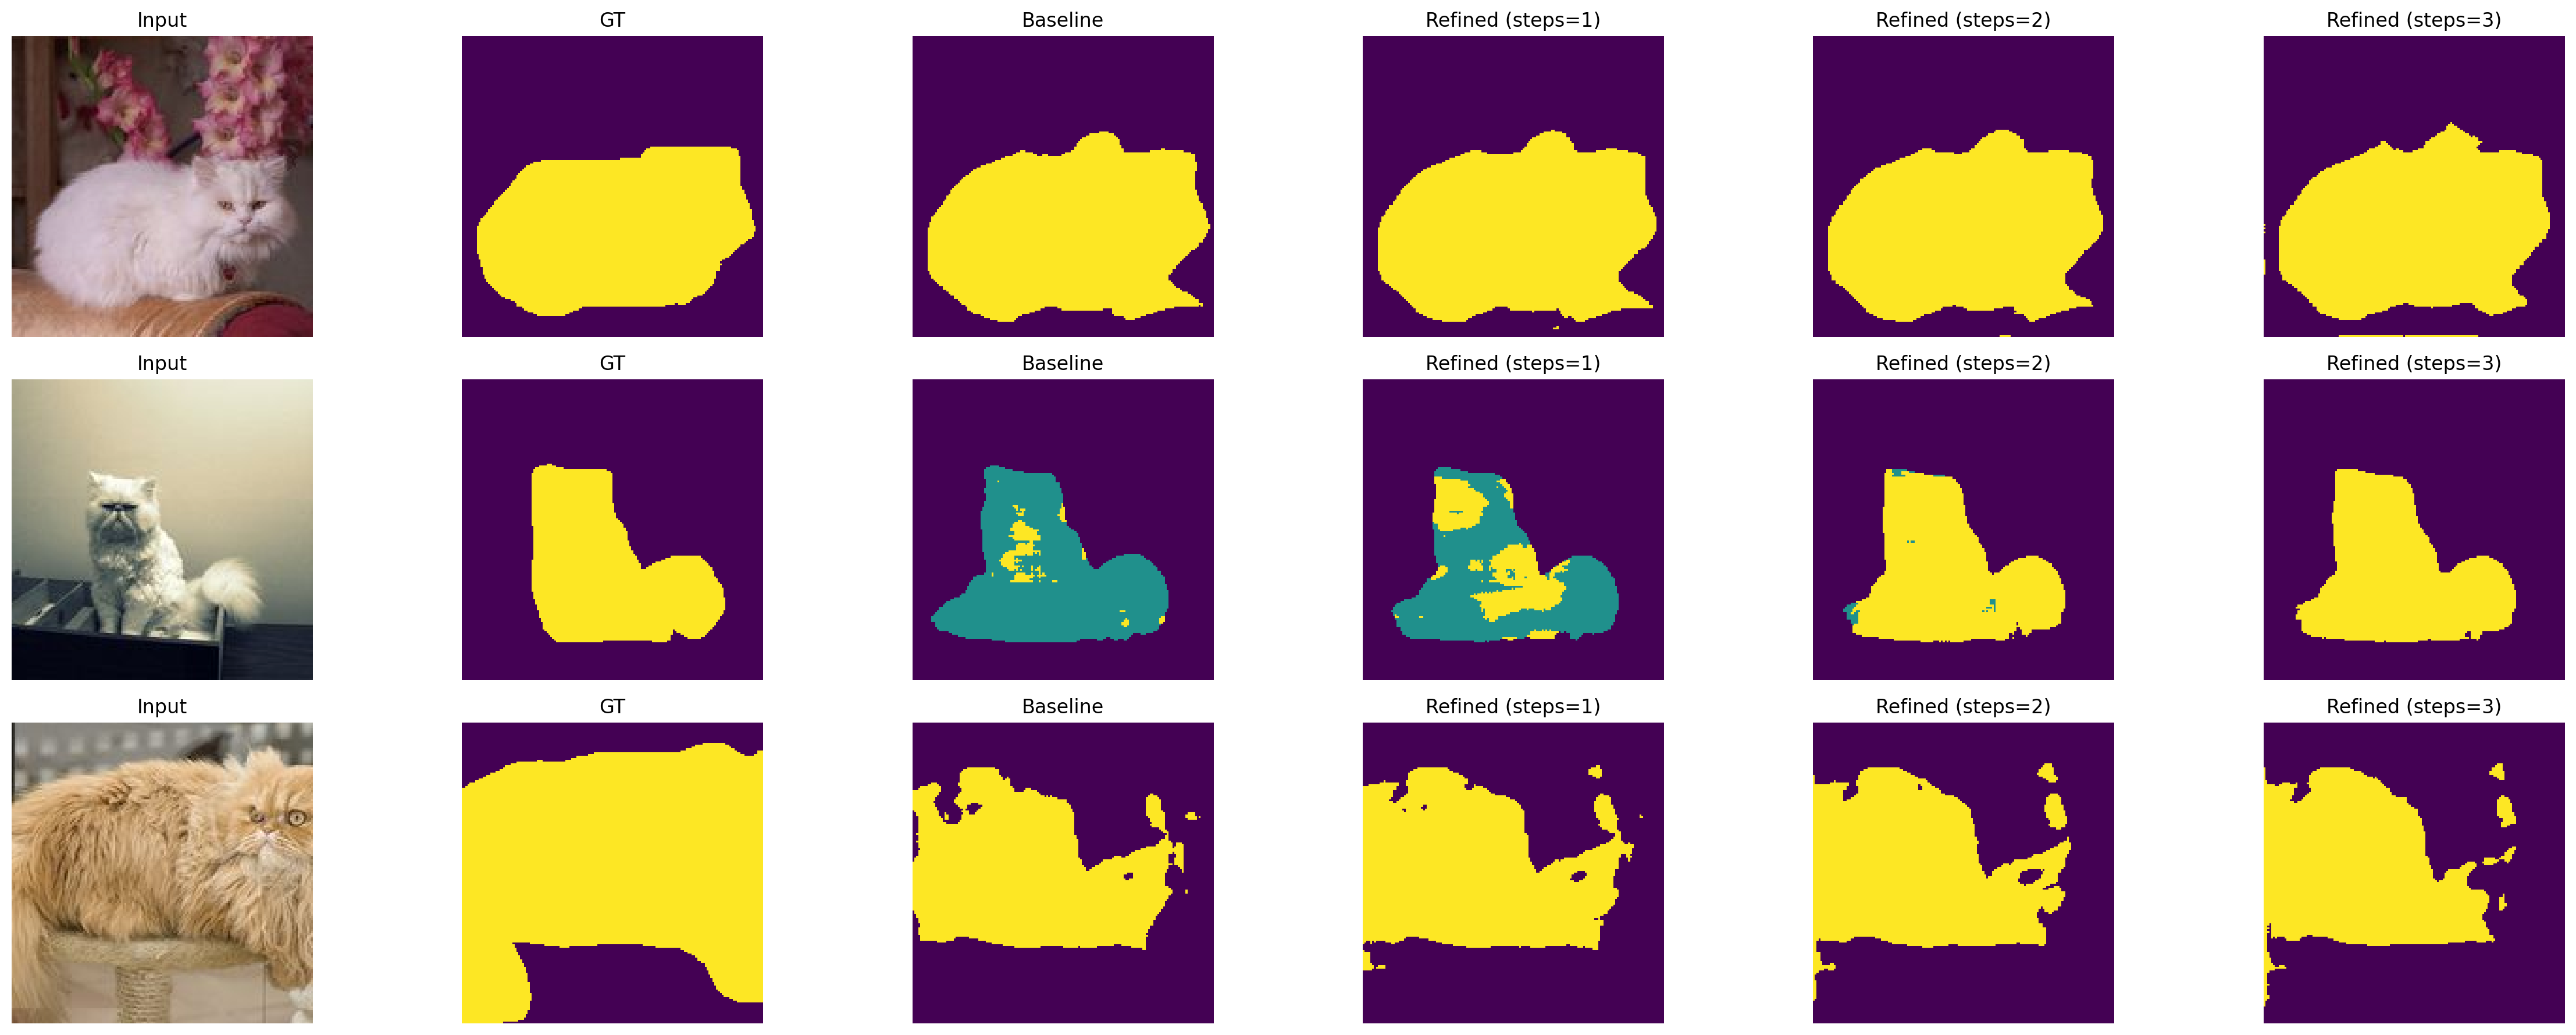

In [56]:
from experiments.diffusion_ablation import (
    run_task4_quant_ablation,
    visualize_baseline_vs_diffusion_steps,
)

# ---- Quantitative + ablation ----
baseline_metrics, df_full_refinement, df_ablation, refined_results_full, ablation_results = \
    run_task4_quant_ablation(
        baseline_model=baseline_model,
        diffusion_model=diffusion_model,
        test_loader=test_loader,
        num_classes=CLASSES,
        device=DEVICE,
        q_sample=q_sample,
        T=T,
        boundary_f1_single=boundary_f1_single,
        steps=(1, 2, 3),
        modes=("full", "no_image", "no_logits", "no_probs"),
    )

display(df_full_refinement)
display(df_ablation)

# Optional: save to Drive
df_full_refinement.to_csv(os.path.join(MODEL_RESULTS_DIR, "task4_baseline_vs_refined.csv"), index=False)
df_ablation.to_csv(os.path.join(MODEL_RESULTS_DIR, "task4_ablation.csv"), index=False)

# ---- Qualitative visualisation for best config ----
best_steps = max(refined_results_full.keys(),
                 key=lambda k: refined_results_full[k]["miou"])
print(f"Best full-conditioning steps by mIoU: {best_steps}")

visualize_baseline_vs_diffusion_steps(
    baseline_model=baseline_model,
    diffusion_model=diffusion_model,
    loader=test_loader,
    q_sample=q_sample,
    T=T,
    mean_rgb=MEAN_RGB,
    std_rgb=STDDEV_RGB,
    steps_to_show=(1, 2, 3),
    t_level=0,
    mode="full",
    num_samples=3,
    device=DEVICE,
)

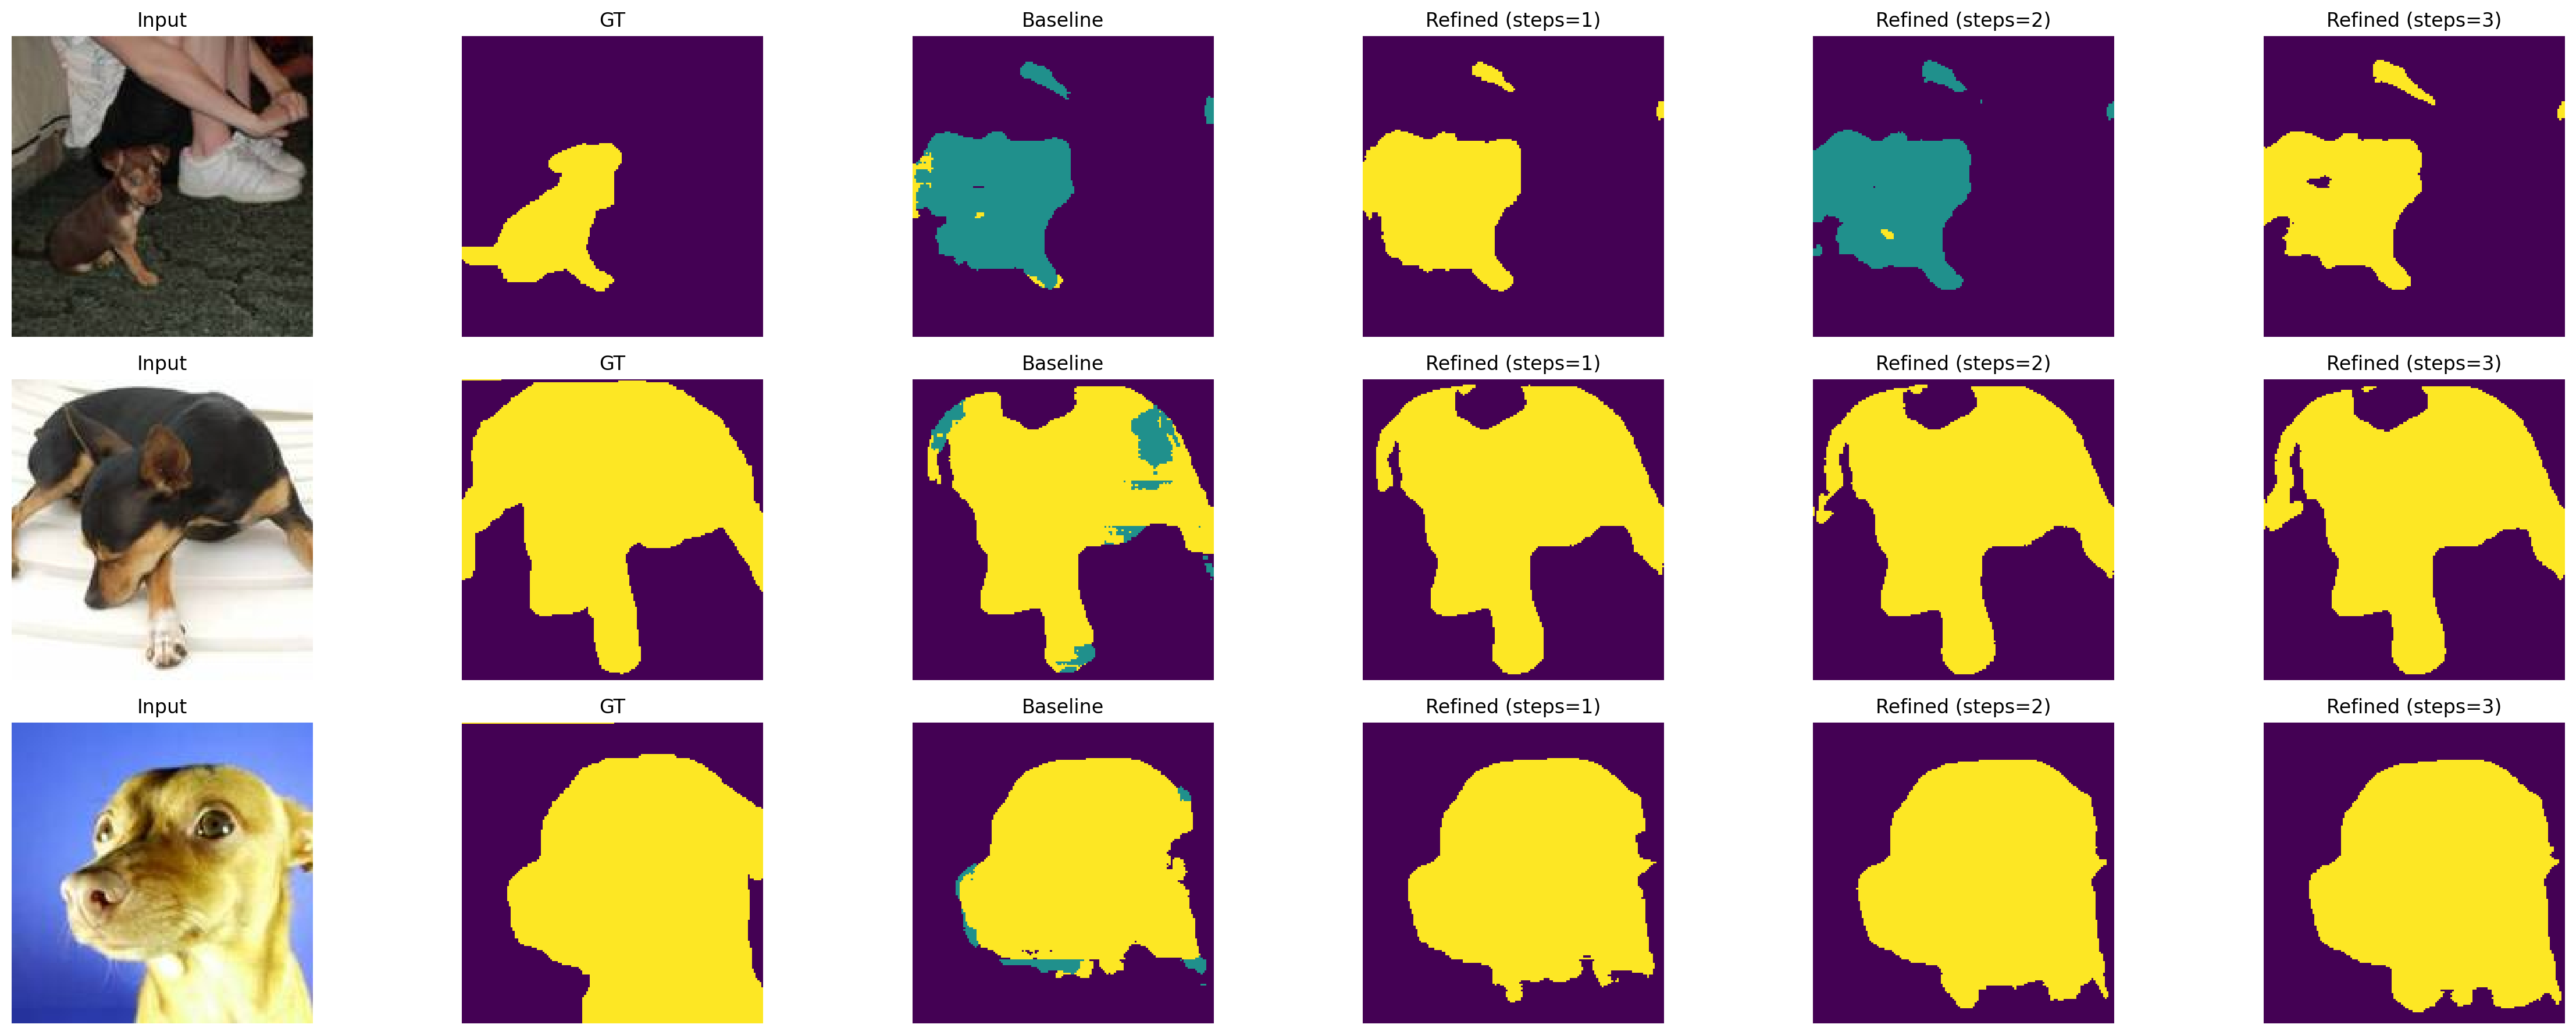

In [60]:
visualize_baseline_vs_diffusion_steps(
    baseline_model=baseline_model,
    diffusion_model=diffusion_model,
    loader=test_loader,
    q_sample=q_sample,
    T=T,
    mean_rgb=MEAN_RGB,
    std_rgb=STDDEV_RGB,
    steps_to_show=(1, 2, 3),
    t_level=best_t,
    mode="full",
    num_samples=3,
    device=DEVICE,
    seed=34
)